# Notebook to compare modelled (MERRA-2, SNOWPACK, RACMO2, and MAR) vs observed SMB from IceBridge snow accumulation radar.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import xarray as xr
from osgeo import osr

## Load observed SMB from Dattler et. al., 2019

In [10]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

# Transform obs lat/lon into epsg 3031

In [11]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

## Load SNOWPACK SMB

In [12]:
nc_path = "../output/grids/a3d_grids.nc"
ds = xr.open_dataset(nc_path)

## Determine SNOWPACK domain corners

In [15]:
domain_left = ds['easting'].min()
domain_right = ds['easting'].max()
domain_bottom = ds['northing'].min()
domain_top = ds['northing'].max()

## Plot observed SMB (blue circles) and model domain (red rectangle)

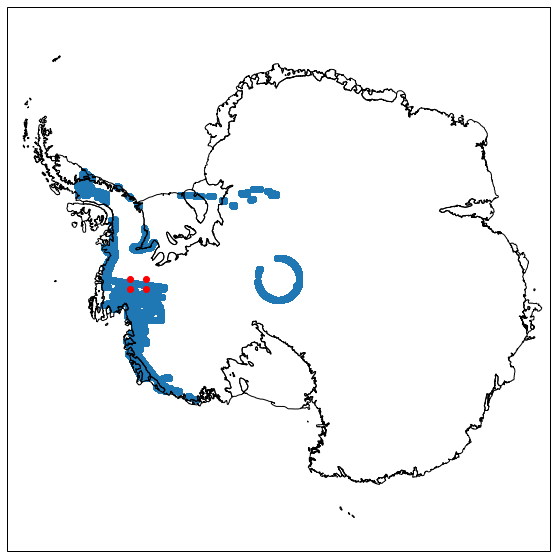

In [19]:
# Coastline Data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot obs locations
plt.scatter(obs_X, obs_Y)

# Plot model domain
plt.scatter(domain_left, domain_bottom, c='r')
plt.scatter(domain_left, domain_top, c='r')
plt.scatter(domain_right, domain_bottom, c='r')
plt.scatter(domain_right, domain_top, c='r')

## Determine indices of observations which are in SNOWPACK model domain

In [23]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, domain_left, domain_right, domain_bottom, domain_top):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    return indices

## Retrieve SNOWPACK and observed SMB 

# Scatter plot of SNOWPACK and observed SMB

## Horizontal ransect of SNOWPACK vs obserced SMB